# Zero shot classification using CLIP.

We use a model from OpenAI for this project. 

Zero shot classification is a task that classifies images into different categories using a model that was not pre-trained on data containing labeled examples from those specific categories. 


In [1]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch


/home/sajalpaudyal/Documents/Programming_Works/AI_agents_with_LLMs/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_used = "openai/clip-vit-large-patch14"
tokenizer = CLIPTokenizerFast.from_pretrained(model_used)
processor = CLIPProcessor.from_pretrained(model_used)
model = CLIPModel.from_pretrained(model_used)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
labels = [
    "France",
    "China",
    "Nepal",
    "England"
]

fs_images = [
    "../images/china.jpg",
    "../images/england.jpg",
    "../images/nepal_flag.jpg",
    "../images/france.jpg",
]

In [4]:
label_embeddings = []

for label in labels:
    inputs = tokenizer(label, return_tensors="pt")
    label_embedding = model.get_text_features(**inputs)
    label_embeddings.append(label_embedding.detach())

In [5]:
label_embeddings = torch.cat(label_embeddings, dim=0)

In [6]:
label_embeddings /= label_embeddings.norm(dim=-1, keepdim=True)

In [7]:
temperature = 0.01

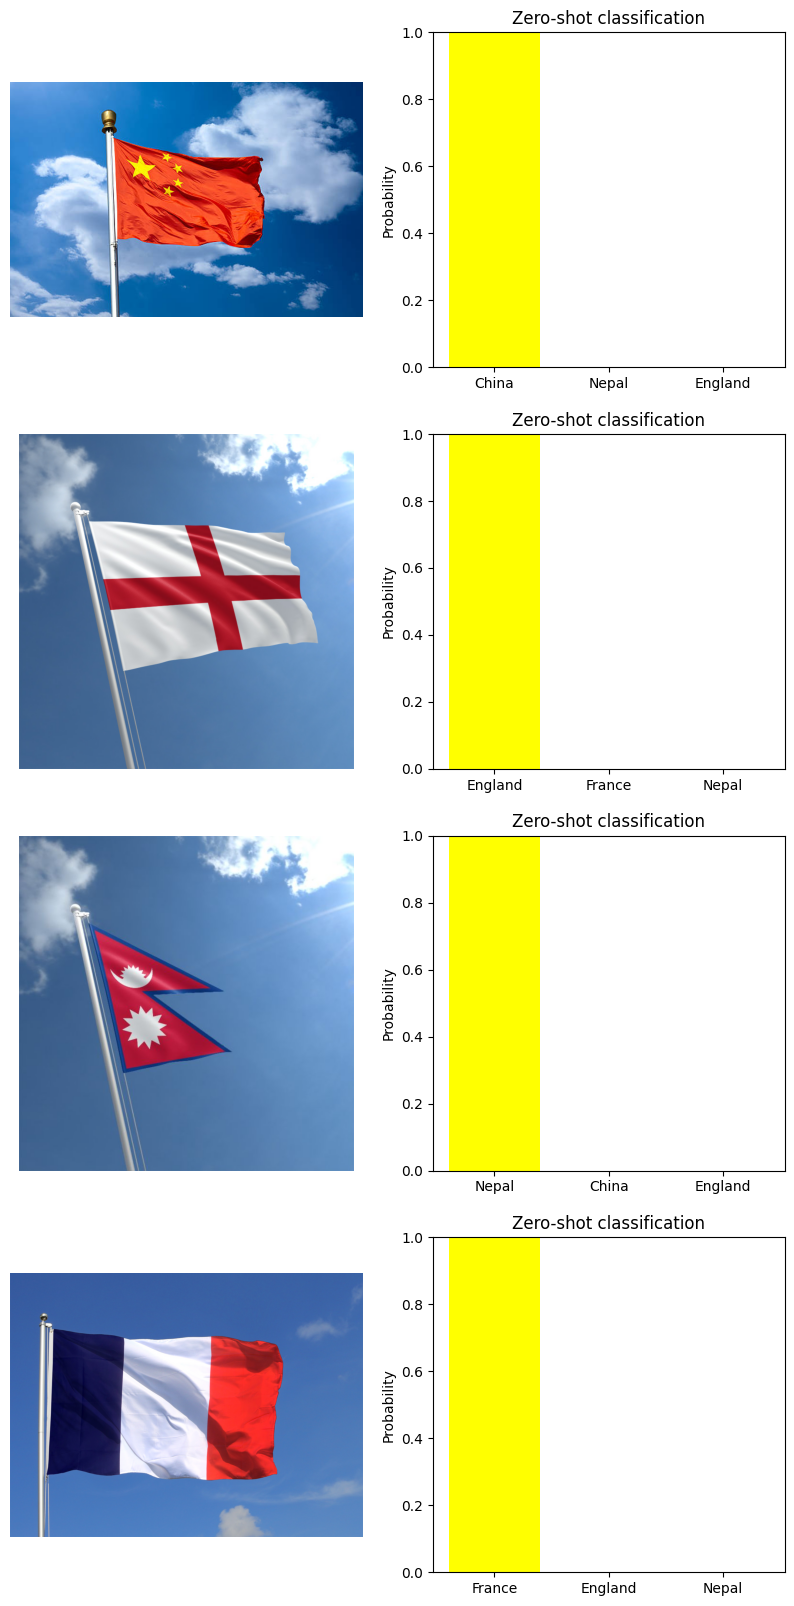

In [8]:
fig, axs = plt.subplots(len(fs_images), 2, figsize = (10, len(fs_images) * 5))


for i, single_image in enumerate(fs_images):
    image = Image.open(single_image).convert("RGB")
    processed_image = processor(text=None, images=image, return_tensors = "pt")["pixel_values"]
    image_embedding = model.get_image_features(processed_image)
    
    
    image_embedding /= image_embedding.norm(dim=1, keepdim=True)
    
    similarity_score = torch.matmul(image_embedding, label_embeddings.T).squeeze() / temperature
    
    probabilities = torch.softmax(similarity_score, dim=-1).detach().numpy()
    
    
    top_indices = probabilities.argsort()[-3:][::-1]
    top_probabilities = probabilities[top_indices]
    top_labels = [labels[idx] for idx in top_indices]
    
    
    top_probabilities /= top_probabilities.sum()
    
    axs[i, 0].imshow(image)
    axs[i,0].axis("off")
    
    axs[i, 1].bar(top_labels, top_probabilities, color="yellow")
    axs[i, 1].set_ylim(0, 1)
    axs[i, 1].set_ylabel("Probability")
    axs[i, 1].set_title("Zero-shot classification")
    